<a href="https://colab.research.google.com/github/mumido/Grupo12_Proyecto_FraudBuster/blob/RNP/Mi_modelo_RNP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#  **Red Neuronal Profunda**

## **Importar Librerías**

Primero, importamos las bibliotecas necesarias para el procesamiento de datos, la creación y el entrenamiento de la red neuronal, así como para la evaluación del modelo:

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import (confusion_matrix, accuracy_score, precision_score,
                             recall_score, f1_score, roc_auc_score, classification_report,
                             precision_recall_curve, roc_curve, auc, brier_score_loss)
from sklearn.calibration import calibration_curve
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
from google.colab import drive

## **Montar Google Drive y Cargar el Dataset**
Se monta Google Drive para acceder a los archivos almacenados allí, en este caso, el dataset.

Leemos el archivo CSV que contiene el dataset de fraude financiero

In [ ]:
# Montar Google Drive
drive.mount('/content/drive')

# Cargar el dataset
file_path = '/content/drive/MyDrive/fraud_detection_dataset.csv'
df = pd.read_csv(file_path)

Mounted at /content/drive


## **Preprocesamiento de Datos**
### **a. Eliminar columnas no deseadas**
Eliminamos las columnas nameOrig y nameDest ya que no son relevantes para el modelo:

In [ ]:
df = df.drop(['nameOrig', 'nameDest'], axis=1)

### **b. Dividir en características (X) y etiquetas (y)**
Separamos el dataset en características (X) y la etiqueta objetivo (y), que es la columna isFraud

In [ ]:
X = df.drop(['isFraud'], axis=1)
y = df['isFraud']

### **c. Identificar columnas categóricas y numéricas**
Identificamos las columnas categóricas (type) y numéricas

In [ ]:
categorical_features = ['type']
numeric_features = X.columns.difference(categorical_features)

### **d. Crear transformador para preprocesar los datos**
Creamos un ColumnTransformer para escalar las características numéricas y codificar las categóricas

In [ ]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(), categorical_features)
    ])

## **Dividir los Datos en Conjuntos de Entrenamiento y Prueba**
Dividimos los datos en conjuntos de entrenamiento y prueba (80% entrenamiento, 20% prueba)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## **Aplicar el Preprocesamiento**
Aplicamos el preprocesamiento a los conjuntos de entrenamiento y prueba

In [ ]:
X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)

## **Definir la Arquitectura de la Red Neuronal**
Creamos la arquitectura de la red neuronal con Keras. La red tiene dos capas ocultas con 128 y 64 neuronas respectivamente y una capa de salida con una sola neurona (para clasificación binaria)*texto en cursiva*

In [ ]:
model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

## **Compilar el Modelo**
Compilamos el modelo con el optimizador Adam y la función de pérdida binaria (ya que es un problema de clasificación binaria)

In [ ]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

## **Definir Callbacks**
Definimos callbacks para detener el entrenamiento temprano si el modelo deja de mejorar y para guardar el mejor modelo

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model.h5', save_best_only=True, monitor='val_loss', mode='min')

## **Entrenar el Modelo**
Entrenamos el modelo usando los datos de entrenamiento y validación

In [ ]:
history = model.fit(X_train, y_train, epochs=20, batch_size=64, validation_split=0.2, callbacks=[early_stopping, model_checkpoint])


Epoch 1/20
63627/63627 [==============================] - 217s 3ms/step - loss: 0.0062 - accuracy: 0.9992 - val_loss: 0.0039 - val_accuracy: 0.9994
Epoch 2/20
   66/63627 [..............................] - ETA: 2:30 - loss: 0.0029 - accuracy: 0.9991

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


63627/63627 [==============================] - 214s 3ms/step - loss: 0.0049 - accuracy: 0.9993 - val_loss: 0.0034 - val_accuracy: 0.9993
Epoch 3/20
63627/63627 [==============================] - 194s 3ms/step - loss: 0.0048 - accuracy: 0.9993 - val_loss: 0.0044 - val_accuracy: 0.9994
Epoch 4/20
63627/63627 [==============================] - 210s 3ms/step - loss: 0.0047 - accuracy: 0.9993 - val_loss: 0.0045 - val_accuracy: 0.9994
Epoch 5/20
63627/63627 [==============================] - 216s 3ms/step - loss: 0.0067 - accuracy: 0.9993 - val_loss: 0.0041 - val_accuracy: 0.9994


## **Evaluar el Modelo**
### **a. Cargar el mejor modelo guardado**
Cargamos el mejor modelo guardado durante el entrenamiento

In [ ]:
model = load_model('best_model.h5')

### **b. Predicciones**
Realizamos predicciones en el conjunto de prueba


In [ ]:
y_pred_prob = model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype("int32")

39767/39767 [==============================] - 64s 2ms/step


### **c. Calcular Métricas**
Calculamos varias métricas de rendimiento

In [ ]:
conf_matrix = confusion_matrix(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_prob)
classification_rep = classification_report(y_test, y_pred)

### **d. Curvas de Evaluación**
Calculamos las curvas de precisión-recall, ROC y calibración

In [ ]:
# Curva de precisión-recall
precision_vals, recall_vals, _ = precision_recall_curve(y_test, y_pred_prob)

In [ ]:
# Curva ROC
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

In [ ]:
# Curva de Calibración
prob_true, prob_pred = calibration_curve(y_test, y_pred_prob, n_bins=10)

## **Visualización de Resultados**
### **a. Matriz de Confusión y Reporte de Clasificación**
Mostramos la matriz de confusión y el reporte de clasificación

In [ ]:
print("Matriz de Confusión:")
print(conf_matrix)
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("ROC AUC Score:", roc_auc)
print("\nClassification Report:")
print(classification_rep)

Matriz de Confusión:
[[1270901       3]
 [    838     782]]
Accuracy: 0.9993391087319374
Precision: 0.9961783439490446
Recall: 0.48271604938271606
F1 Score: 0.6503118503118503
ROC AUC Score: 0.9908439493307495

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1270904
           1       1.00      0.48      0.65      1620

    accuracy                           1.00   1272524
   macro avg       1.00      0.74      0.82   1272524
weighted avg       1.00      1.00      1.00   1272524



### **b. Curvas de Aprendizaje**
Visualizamos las curvas de aprendizaje (accuracy y loss)

Text(0.5, 1.0, 'Loss Curves')

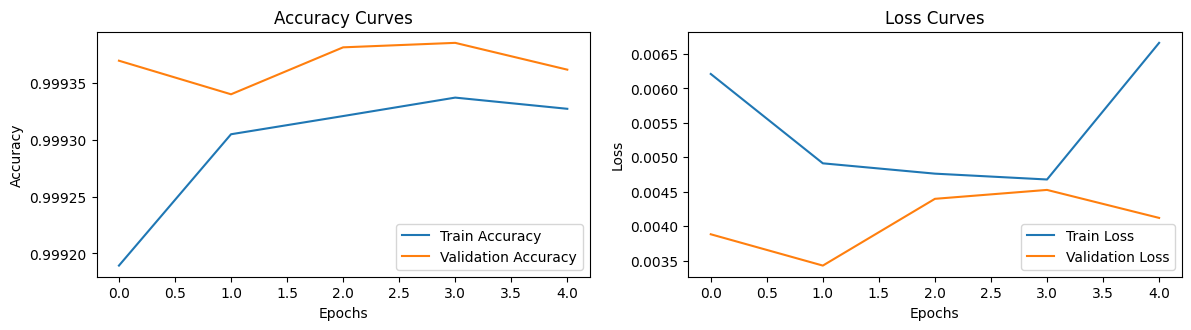

In [ ]:
plt.figure(figsize=(14, 7))
plt.subplot(2, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy Curves')

plt.subplot(2, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss Curves')


### **c. Curvas de Precisión-Recall y ROC**
Visualizamos las curvas de precisión-recall y ROC

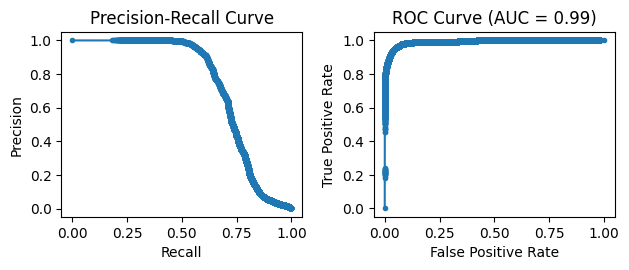

In [ ]:
plt.subplot(2, 2, 3)
plt.plot(recall_vals, precision_vals, marker='.')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')

plt.subplot(2, 2, 4)
plt.plot(fpr, tpr, marker='.')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (AUC = {:.2f})'.format(roc_auc))

plt.tight_layout()
plt.show()

### **d. Curva de Calibración**
Visualizamos la curva de calibración

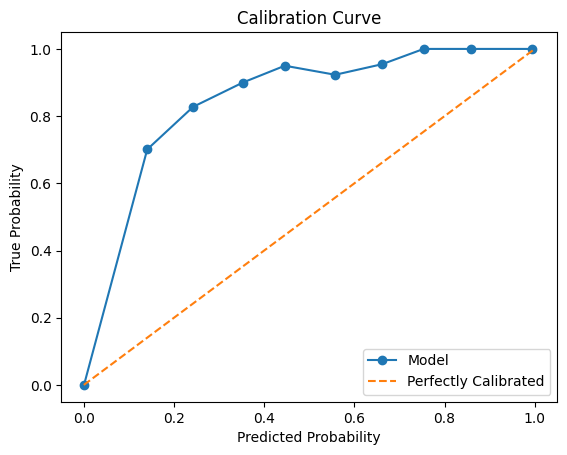

In [ ]:
plt.figure()
plt.plot(prob_pred, prob_true, marker='o', label='Model')
plt.plot([0, 1], [0, 1], linestyle='--', label='Perfectly Calibrated')
plt.xlabel('Predicted Probability')
plt.ylabel('True Probability')
plt.title('Calibration Curve')
plt.legend()
plt.show()

## **Brier Score**
Calculamos el Brier Score para evaluar la precisión de las probabilidades predichas

In [ ]:
brier_score = brier_score_loss(y_test, y_pred_prob)
print('Brier Score:', brier_score)

Brier Score: 0.0005999484726180342


## **Prueba de Robustez y Generalización**
Evaluamos la robustez y generalización del modelo en datos de prueba no vistos anteriormente

In [ ]:
print("Robustez y Generalización:")
print("Evaluación con datos de prueba no vistos anteriormente:")
y_test_pred_prob = model.predict(X_test)
y_test_pred = (y_test_pred_prob > 0.5).astype("int32")

accuracy_test = accuracy_score(y_test, y_test_pred)
precision_test = precision_score(y_test, y_test_pred)
recall_test = recall_score(y_test, y_test_pred)
f1_test = f1_score(y_test, y_test_pred)
roc_auc_test = roc_auc_score(y_test, y_test_pred_prob)

print("Accuracy:", accuracy_test)
print("Precision:", precision_test)
print("Recall:", recall_test)
print("F1 Score:", f1_test)
print("ROC AUC Score:", roc_auc_test)

Robustez y Generalización:
Evaluación con datos de prueba no vistos anteriormente:
39767/39767 [==============================] - 68s 2ms/step
Accuracy: 0.9993391087319374
Precision: 0.9961783439490446
Recall: 0.48271604938271606
F1 Score: 0.6503118503118503
ROC AUC Score: 0.9908439493307495


## **Resumen**
El objetivo principal de este código es entrenar una red neuronal profunda para detectar fraudes financieros en transacciones. Esto se logra a través de:

* **Preprocesamiento de Datos**: Transformación de características
numéricas y categóricas.
* **Definición y Entrenamiento de la Red Neuronal**: Creación y entrenamiento de un modelo de red neuronal utilizando Keras.
* **Evaluación del Modelo**: Evaluación exhaustiva del rendimiento del modelo usando múltiples métricas y visualizaciones.
* **Prueba de Generalización**: Asegurarse de que el modelo generalice bien en datos no vistos anteriormente.

Este proceso ayuda a identificar transacciones fraudulentas basadas en los datos históricos proporcionados.